1) prendre les données de la bdd backend
2) transphormer en dataframe pandas séparé
3) checks les données et filtré 
4) tout reliée ensemble
5) setup pour faire un model
6) test le model



a prendre un compte on as des cas bcs d'infos mais au longthemre c'est dur de vraiment déterminé quels valeurs on a acces ou non
dans un sens il faudrait faire plusieurs models pour les différents cas de figure dépendant des valeurs manquants.


// dans notre 1er cas on vas seulement se concentré sur les accidents pour :

la gravité de l'accident pour le conducteur
On as 3 options pour les autres information :
- NE que prendre en compte 1 piéton et précisé sa localisation
- prendre en compte TOUT les piétons sans la localisation
- prendre en compte TOUT les piétons et leurs localisations
--> presque que des 0 ou 1 alors on vas géré les cas les plus probables pour l'instant : 
géré max 1 piéton les autres row on delete.

In [37]:
import requests
from typing import List, Dict, Union

def fetch_api_data(base_url: str, table_name: str) -> Union[List[Dict], None]:
    """
    Fetches data from a FastAPI endpoint like http://localhost:8000/{table_name}

    Args:
        base_url (str): Base URL of the API, e.g., "http://localhost:8000"
        table_name (str): The name of the endpoint table, e.g., "caracts"

    Returns:
        List of dicts if successful, None otherwise
    """
    url = f"{base_url.rstrip('/')}/{table_name.lstrip('/')}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching {table_name} from {url}: {e}")
        return None


In [38]:

import unicodedata

def remove_accents(text):
    if isinstance(text, str):
        text = unicodedata.normalize('NFD', text)
        text = ''.join(ch for ch in text if unicodedata.category(ch) != 'Mn')
        return text
    return text

Filtre des caracteristiques :

In [39]:
import pandas as pd

base_url = "http://localhost:8000"
table_name = "caracts"

data = fetch_api_data(base_url, table_name)

if data:
    df_caract = pd.DataFrame(data)
    df_caract.head()  # Print just the first few rows
else:
    print("No data found.")

# df_caract.dropna(subset=['adr'], inplace=True) just pas uen variable utilisable.
df_caract.reset_index(drop=True, inplace=True)
df_caract.drop(columns=["id"], inplace=True)
df_caract.drop(columns=['adr'], inplace=True)
df_caract.drop(columns=["com"], inplace=True)



for col in df_caract.select_dtypes(include='object'):
    df_caract[col] = df_caract[col].str.strip()

In [40]:
def time_to_fraction(time_str):
    try:
        hours, minutes = map(int, time_str.split(":"))
        total_minutes = hours * 60 + minutes
        return total_minutes / (24 * 60)  # Normalize to [0,1]
    except:
        return None  # or np.nan

# Apply to your DataFrame
df_caract["hrmn_scaled"] = df_caract["hrmn"].apply(time_to_fraction)
df_caract.drop(columns=['hrmn'], inplace=True)


In [41]:
df_caract.head()

,id_accident,jour,mois,an,lum,dep,agg,int_,atm,col,lat,long,date_ajout,hrmn_scaled
0,202300000001,7,5,2023,1,75,2,4,2,7,48.866386,2.323471,2025-08-12T20:01:07.275324,0.250000
1,202300000002,7,5,2023,5,94,2,1,3,6,48.845478,2.428681,2025-08-12T20:01:07.281840,0.229167
2,202300000003,7,5,2023,1,94,2,3,2,1,48.762400,2.406550,2025-08-12T20:01:07.283367,0.868056
3,202300000004,6,5,2023,5,94,2,1,3,5,48.732484,2.446876,2025-08-12T20:01:07.284611,0.997917
4,202300000005,7,5,2023,5,94,2,2,3,3,48.785810,2.492170,2025-08-12T20:01:07.285704,0.034722


In [42]:
df_caract["dep"].nunique()


107

on as 107 département unique ce que je trouve correct pour du One-Hot Encoding à 1er vue.
Mais il y a beaucoup trop de comune(11311), je ne pense pas qu'on vas être capable d'en faire qlq chose d'utile.

Filtre des lieux :
avancé inutiles : crée une nouvelle colonnes depuis les valeurs de la colonne "voie" on as en soit déjà tout sur la colonne categorie.


In [43]:
import pandas as pd

base_url = "http://localhost:8000"
table_name = "lieux"

data = fetch_api_data(base_url, table_name)

if data:
    df_lieux = pd.DataFrame(data)
    df_lieux.head()  # Print just the first few rows
else:
    print("No data found.")

for col in df_lieux.select_dtypes(include='object'):
    df_lieux[col] = df_lieux[col].str.strip().str.lower().apply(remove_accents)
df_lieux.drop(columns=['voie'], inplace=True)
df_lieux.drop(columns=['v1'], inplace=True)
df_lieux.drop(columns=['v2'], inplace=True)
df_lieux.drop(columns=['id'], inplace=True)
# trop d'options différentes pour cette variable je ne sais pas la quel traiter.
df_lieux.drop(columns=['nbv'], inplace=True)


df_lieux.drop(columns=['lartpc'], inplace=True)




In [44]:
df_lieux.head()

,id_accident,catr,circ,vosp,prof,pr,pr1,plan,larrout,surf,infra,situ,vma,date_ajout
0,202300000001,4,1,0,1,-1,-1,1,-1.0,2,0,1,30,2025-08-12t20:44:07
1,202300000001,4,1,0,1,-1,-1,1,-1.0,2,0,1,30,2025-08-12t20:44:07
2,202300000002,3,2,2,1,-1,-1,1,-1.0,2,0,1,50,2025-08-12t20:44:07
3,202300000003,3,2,0,1,1,0,1,-1.0,2,5,1,50,2025-08-12t20:44:07
4,202300000003,3,2,0,1,1,0,1,-1.0,2,5,1,50,2025-08-12t20:44:07


In [45]:
import pandas as pd

base_url = "http://localhost:8000"
table_name = "usagers"

data = fetch_api_data(base_url, table_name)

if data:
    df_usagers = pd.DataFrame(data)
    df_usagers.head()  # Print just the first few rows
else:
    print("No data found.")

df_usagers.dropna(subset=['an_nais'], inplace=True)
df_usagers.reset_index(drop=True, inplace=True)
for col in df_usagers.select_dtypes(include='object'):
    df_usagers[col] = df_usagers[col].str.strip()

df_usagers.drop(columns=['id'], inplace=True)

#Je ne sais pas ce que c'est 
df_usagers.drop(columns=['num_veh'], inplace=True)  
df_usagers.drop(columns=['catu'], inplace=True)  # redondance trop grosse avec la colonne place 

#je supose que c'est pas des information visibles 
df_usagers.drop(columns=['secu1'], inplace=True)
df_usagers.drop(columns=['secu2'], inplace=True)
df_usagers.drop(columns=['secu3'], inplace=True)
#de même je ne sais pas l'état de la personne, ni le trajet
df_usagers.drop(columns=['etatp'], inplace=True)
df_usagers.drop(columns=['trajet'], inplace=True)
#posssible en soit d'avoir un model qui d'étermine l'action de la personne, mais pas dans notre cas
df_usagers.drop(columns=['actp'], inplace=True) 

#location du piétion (= place 10 je suppose)

In [46]:
df_usagers.head()
#etatp , trajet, secu1...3, actp, catu, num_veh
#seulement faire pour la place 1

,id_accident,id_usager,id_vehicule,place,grav,sexe,an_nais,locp,date_ajout
0,202300000001,203851184,155680557,1,4,1,1978.0,-1,2025-08-12T20:44:08
1,202300000002,203851182,155680556,1,1,2,1997.0,-1,2025-08-12T20:44:08
2,202300000002,203851183,155680556,10,3,1,1997.0,2,2025-08-12T20:44:08
3,202300000003,203851180,155680554,1,3,1,1987.0,0,2025-08-12T20:44:08
4,202300000003,203851181,155680555,1,1,2,1984.0,0,2025-08-12T20:44:08


In [47]:
import pandas as pd

# Count passengers (place 2 to 9) per accident
passagers_counts = df_usagers[df_usagers["place"].between(2, 9)].groupby("id_accident").size().rename("n_passager")

# Count pedestrians (place == 10) per accident
pieton_counts = df_usagers[df_usagers["place"] == 10].groupby("id_accident").size().rename("n_pieton")

# Filter only conducteurs (place == 1)
df_conducteurs = df_usagers[df_usagers["place"] == 1].copy()

# Merge both counts into the conducteur dataframe
df_conducteurs = df_conducteurs.merge(passagers_counts, on="id_accident", how="left")
df_conducteurs = df_conducteurs.merge(pieton_counts, on="id_accident", how="left")

# Fill NaN with 0
df_conducteurs["n_passager"] = df_conducteurs["n_passager"].fillna(0).astype(int)
df_conducteurs["n_pieton"] = df_conducteurs["n_pieton"].fillna(0).astype(int)

# Result
df_conducteurs.head()


,id_accident,id_usager,id_vehicule,place,grav,sexe,an_nais,locp,date_ajout,n_passager,n_pieton
0,202300000001,203851184,155680557,1,4,1,1978.0,-1,2025-08-12T20:44:08,0,0
1,202300000002,203851182,155680556,1,1,2,1997.0,-1,2025-08-12T20:44:08,0,2
2,202300000003,203851180,155680554,1,3,1,1987.0,0,2025-08-12T20:44:08,0,0
3,202300000003,203851181,155680555,1,1,2,1984.0,0,2025-08-12T20:44:08,0,0
4,202300000004,203851176,155680551,1,1,2,1995.0,-1,2025-08-12T20:44:08,4,0


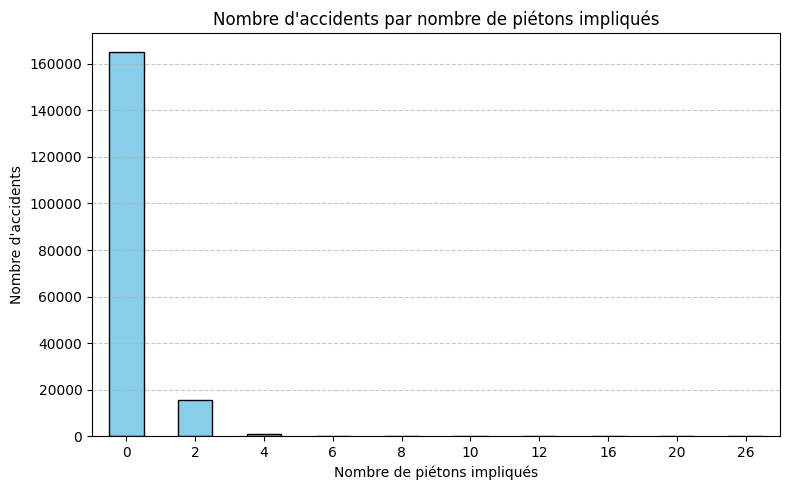

In [48]:
import matplotlib.pyplot as plt

# Compter combien d'accidents ont 0, 1, 2, ... piétons impliqués
pieton_distribution = df_conducteurs["n_pieton"].value_counts().sort_index()

# Tracer le graphique
plt.figure(figsize=(8, 5))
pieton_distribution.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Nombre d'accidents par nombre de piétons impliqués")
plt.xlabel("Nombre de piétons impliqués")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [49]:
df_conducteurs = df_conducteurs[df_conducteurs["n_pieton"] <= 1]


In [50]:
# Step 1: Filter df_conducteurs where there's exactly 1 pedestrian
mask_pieton_1 = df_conducteurs["n_pieton"] == 1
df_with_1_pieton = df_conducteurs[mask_pieton_1].copy()

# Step 2: For each of those rows, replace locp with that of the pedestrian in df_usagers
for idx, row in df_with_1_pieton.iterrows():
    accident_id = row["id_accident"]

    # Get the corresponding pedestrian (place == 10) from df_usagers
    pieton_row = df_usagers[(df_usagers["id_accident"] == accident_id) & (df_usagers["place"] == 10)]

    if not pieton_row.empty:
        # If there's a pedestrian, get their locp
        pieton_locp = pieton_row.iloc[0]["locp"]

        # Replace driver's locp with the pedestrian's locp
        df_conducteurs.loc[idx, "locp"] = pieton_locp
df_conducteurs.head()

,id_accident,id_usager,id_vehicule,place,grav,sexe,an_nais,locp,date_ajout,n_passager,n_pieton
0,202300000001,203851184,155680557,1,4,1,1978.0,-1,2025-08-12T20:44:08,0,0
2,202300000003,203851180,155680554,1,3,1,1987.0,0,2025-08-12T20:44:08,0,0
3,202300000003,203851181,155680555,1,1,2,1984.0,0,2025-08-12T20:44:08,0,0
4,202300000004,203851176,155680551,1,1,2,1995.0,-1,2025-08-12T20:44:08,4,0
5,202300000004,203851177,155680552,1,1,1,1968.0,-1,2025-08-12T20:44:08,4,0


In [51]:
# Replace all locp values of -1 with 0
df_conducteurs["locp"] = df_conducteurs["locp"].replace(-1, 0)

# Drop the 'place' column
df_conducteurs.drop(columns=["place"], inplace=True)

# Reset the index
df_conducteurs.reset_index(drop=True, inplace=True)

In [52]:

df_conducteurs.head()

,id_accident,id_usager,id_vehicule,grav,sexe,an_nais,locp,date_ajout,n_passager,n_pieton
0,202300000001,203851184,155680557,4,1,1978.0,0,2025-08-12T20:44:08,0,0
1,202300000003,203851180,155680554,3,1,1987.0,0,2025-08-12T20:44:08,0,0
2,202300000003,203851181,155680555,1,2,1984.0,0,2025-08-12T20:44:08,0,0
3,202300000004,203851176,155680551,1,2,1995.0,0,2025-08-12T20:44:08,4,0
4,202300000004,203851177,155680552,1,1,1968.0,0,2025-08-12T20:44:08,4,0


In [53]:
import pandas as pd

base_url = "http://localhost:8000"
table_name = "vehicules"

data = fetch_api_data(base_url, table_name)

if data:
    df_vehicules = pd.DataFrame(data)
    df_vehicules.head()  # Print just the first few rows
else:
    print("No data found.")


for col in df_vehicules.select_dtypes(include='object'):
    df_vehicules[col] = df_vehicules[col].str.strip()
df_vehicules.drop(columns=['occutc'], inplace=True)
df_vehicules.drop(columns=['num_veh'], inplace=True)
df_vehicules.drop(columns=['id'], inplace=True)




In [54]:
df_vehicules.describe(include='all')

,id_accident,id_vehicule,senc,catv,obs,obsm,choc,manv,motor,date_ajout
count,1.871700e+05,1.871700e+05,187170.000000,187170.000000,187170.000000,187170.000000,187170.000000,187170.000000,187170.000000,187170
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93744
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-08-12T20:46:24
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,820
mean,2.023000e+11,1.556320e+08,1.593589,13.679949,1.050307,1.655297,2.877117,6.772122,1.304515,NaN
std,1.581610e+04,2.806001e+04,0.817013,14.636181,3.168671,1.258313,2.413484,7.792530,1.141440,NaN
min,2.023000e+11,1.555833e+08,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
25%,2.023000e+11,1.556077e+08,1.000000,7.000000,0.000000,1.000000,1.000000,1.000000,1.000000,NaN
50%,2.023000e+11,1.556320e+08,1.000000,7.000000,0.000000,2.000000,2.000000,2.000000,1.000000,NaN
75%,2.023000e+11,1.556563e+08,2.000000,10.000000,0.000000,2.000000,4.000000,14.000000,1.000000,NaN


In [55]:
df_vehicules.head()
#motor estimable avec plaque d'immatriculation

,id_accident,id_vehicule,senc,catv,obs,obsm,choc,manv,motor,date_ajout
0,202300000001,155680557,1,30,0,0,5,1,1,2025-08-12T20:44:09
1,202300000002,155680556,2,7,0,1,1,1,1,2025-08-12T20:44:09
2,202300000003,155680554,1,2,0,2,1,16,1,2025-08-12T20:44:09
3,202300000003,155680555,2,7,0,2,2,15,1,2025-08-12T20:44:09
4,202300000004,155680551,1,7,0,2,9,2,4,2025-08-12T20:44:09


Situation actuelle :
ATTENTION j'ai besoin de check les corrélations avant !!

1) embeding vs One-Hot Encoding ? 
2) relié toutes les colonnes ensembles
3) test des models.

message brouillon pour gaspard A REVOIRS QUAND J'AURAIS FAIT LES CORELATIONS:
ok je suis entrain de finalisé un 1er model pour pouvoir au moins bien faire la partis mlops.
Mais j'ai une question,  dans mon cas sur ce projet j'ai beaucoup de encoding ou embedings à faire.
j'ai bien une variable : comune(11311) variable, vue l'étendus de mon dataset et le nombre d'encoding à faire je ne le trouve pas pertinent à regard d'humain.

un soucis que j'ai sur mes autres variable catégorique c'est que j'en est beaucoup alors je vais être obligé d'avoir beaucoup de hot-one encoding (à chaud je dirais 25 colones pertinantes à faire du hot one encoding)

In [56]:
# tout lié ensemble 
df_vehicules
df_conducteurs
df_lieux
df_caract

,id_accident,jour,mois,an,lum,dep,agg,int_,atm,col,lat,long,date_ajout,hrmn_scaled
0,202300000001,7,5,2023,1,75,2,4,2,7,48.866386,2.323471,2025-08-12T20:01:07.275324,0.250000
1,202300000002,7,5,2023,5,94,2,1,3,6,48.845478,2.428681,2025-08-12T20:01:07.281840,0.229167
2,202300000003,7,5,2023,1,94,2,3,2,1,48.762400,2.406550,2025-08-12T20:01:07.283367,0.868056
3,202300000004,6,5,2023,5,94,2,1,3,5,48.732484,2.446876,2025-08-12T20:01:07.284611,0.997917
4,202300000005,7,5,2023,5,94,2,2,3,3,48.785810,2.492170,2025-08-12T20:01:07.285704,0.034722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164461,202300054818,26,10,2023,5,974,2,1,1,6,-21.338280,55.477710,2025-08-13T10:07:58.972336,0.864583
164462,202300054819,26,10,2023,3,974,1,1,1,3,-21.288650,55.509940,2025-08-13T10:07:58.974198,0.798611
164463,202300054820,26,10,2023,1,974,2,1,1,7,-20.901290,55.405980,2025-08-13T10:07:58.976095,0.402778
164464,202300054821,26,10,2023,1,973,1,6,1,3,4.897130,-52.328540,2025-08-13T10:07:58.978137,0.722222


In [57]:
print(len(df_caract))
print(len(df_lieux))
print(len(df_vehicules))
print(len(df_conducteurs))

164466
141720
187170
165052


In [58]:
dfs = {
    'df_caract': df_caract,
    'df_lieux': df_lieux,
    'df_vehicules': df_vehicules,
    'df_conducteurs': df_conducteurs
}

for name, df in dfs.items():
    total_rows = len(df)
    duplicate_rows = df.duplicated(keep=False).sum()
    print(f"{name}:")
    print(f"  Total rows: {total_rows}")
    print(f"  Fully duplicated rows: {duplicate_rows}\n")



df_caract:
  Total rows: 164466
  Fully duplicated rows: 0

df_lieux:
  Total rows: 141720
  Fully duplicated rows: 4340

df_vehicules:
  Total rows: 187170
  Fully duplicated rows: 0

df_conducteurs:
  Total rows: 165052
  Fully duplicated rows: 0



In [59]:
df_conducteurs.head()

,id_accident,id_usager,id_vehicule,grav,sexe,an_nais,locp,date_ajout,n_passager,n_pieton
0,202300000001,203851184,155680557,4,1,1978.0,0,2025-08-12T20:44:08,0,0
1,202300000003,203851180,155680554,3,1,1987.0,0,2025-08-12T20:44:08,0,0
2,202300000003,203851181,155680555,1,2,1984.0,0,2025-08-12T20:44:08,0,0
3,202300000004,203851176,155680551,1,2,1995.0,0,2025-08-12T20:44:08,4,0
4,202300000004,203851177,155680552,1,1,1968.0,0,2025-08-12T20:44:08,4,0


In [60]:
df_lieux_duplicates = df_lieux.drop_duplicates().reset_index(drop=True)


In [61]:
dfs = {
    'df_caract': df_caract,
    'df_lieux_duplicates': df_lieux_duplicates,
    'df_vehicules': df_vehicules,
    'df_conducteurs': df_conducteurs
}

for name, df in dfs.items():
    total_rows = len(df)
    duplicate_rows = df.duplicated(keep=False).sum()
    
    # Count how many accident IDs appear more than once
    accident_counts = df['id_accident'].value_counts()
    duplicated_accidents = accident_counts[accident_counts > 1]
    num_duplicated_accidents = len(duplicated_accidents)
    
    print(f"{name}:")
    print(f"  Total rows: {total_rows}")
    print(f"  Fully duplicated rows: {duplicate_rows}")
    print(f"  Number of id_accident duplicated: {num_duplicated_accidents}\n")

df_caract:
  Total rows: 164466
  Fully duplicated rows: 0
  Number of id_accident duplicated: 54822

df_lieux_duplicates:
  Total rows: 139541
  Fully duplicated rows: 0
  Number of id_accident duplicated: 54822

df_vehicules:
  Total rows: 187170
  Fully duplicated rows: 0
  Number of id_accident duplicated: 54822

df_conducteurs:
  Total rows: 165052
  Fully duplicated rows: 0
  Number of id_accident duplicated: 45974



In [62]:
df_lieux_duplicates = df_lieux_duplicates.drop_duplicates(subset='id_accident', keep='first')


In [63]:
# # Filter only duplicated rows (based on 'id_accident')
# dups = df_lieux_duplicates[df_lieux_duplicates.duplicated(subset='id_accident', keep=False)]

# # Group by 'id_accident' to work on each group of duplicates
# def merge_duplicates(group):
#     # Replace -1 or 0 by the non (-1 or 0) value from the same group
#     for col in group.columns:
#         if col == 'id_accident':
#             continue
#         values = group[col].values
#         valid = [v for v in values if v not in [-1, 0]]
#         if valid:
#             group[col] = [v if v not in [-1, 0] else valid[0] for v in values]
#     return group

# # Apply the merging logic
# dups_fixed = dups.groupby('id_accident', group_keys=False).apply(merge_duplicates)

# # Update the original DataFrame with the corrected values
# df_lieux_duplicates.update(dups_fixed)


In [64]:
df_lieux_duplicates = df_lieux_duplicates.drop_duplicates().reset_index(drop=True)


In [65]:
dfs = {
    'df_caract': df_caract,
    'df_lieux_duplicates': df_lieux_duplicates,
    'df_vehicules': df_vehicules,
    'df_conducteurs': df_conducteurs
}

for name, df in dfs.items():
    total_rows = len(df)
    duplicate_rows = df.duplicated(keep=False).sum()
    
    # Count how many accident IDs appear more than once
    accident_counts = df['id_accident'].value_counts()
    duplicated_accidents = accident_counts[accident_counts > 1]
    num_duplicated_accidents = len(duplicated_accidents)
    print(f"{name}:")
    print(f"  Total rows: {total_rows}")
    print(f"  Fully duplicated rows: {duplicate_rows}")
    print(f"  Number of id_accident duplicated: {num_duplicated_accidents}\n")

df_caract:
  Total rows: 164466
  Fully duplicated rows: 0
  Number of id_accident duplicated: 54822

df_lieux_duplicates:
  Total rows: 54822
  Fully duplicated rows: 0
  Number of id_accident duplicated: 0

df_vehicules:
  Total rows: 187170
  Fully duplicated rows: 0
  Number of id_accident duplicated: 54822

df_conducteurs:
  Total rows: 165052
  Fully duplicated rows: 0
  Number of id_accident duplicated: 45974



In [90]:
# Drop date_ajout from all DataFrames if it exists
for df in [df_conducteurs, df_vehicules, df_lieux_duplicates, df_caract]:
    if 'date_ajout' in df.columns:
        df.drop(columns=['date_ajout'], inplace=True)

# Merge all together on relevant keys
merged_df = pd.merge(
    df_conducteurs,
    df_vehicules,
    on=['id_vehicule', 'id_accident'],  # merge on both keys to avoid _x/_y
    how='inner'
)
merged_df = pd.merge(merged_df, df_lieux_duplicates, on='id_accident', how='inner')
merged_df = pd.merge(merged_df, df_caract, on='id_accident', how='inner')

print(len(merged_df))
merged_df.head()



990312


,id_accident,id_usager,id_vehicule,grav,sexe,an_nais,locp,n_passager,n_pieton,senc,...,an,lum,dep,agg,int_,atm,col,lat,long,hrmn_scaled
0,202300000001,203851184,155680557,4,1,1978.0,0,0,0,1,...,2023,1,75,2,4,2,7,48.866386,2.323471,0.25
1,202300000001,203851184,155680557,4,1,1978.0,0,0,0,1,...,2023,1,75,2,4,2,7,48.866386,2.323471,0.25
2,202300000001,203851184,155680557,4,1,1978.0,0,0,0,1,...,2023,1,75,2,4,2,7,48.866386,2.323471,0.25
3,202300000001,203851184,155680557,4,1,1978.0,0,0,0,1,...,2023,1,75,2,4,2,7,48.866386,2.323471,0.25
4,202300000001,203851184,155680557,4,1,1978.0,0,0,0,1,...,2023,1,75,2,4,2,7,48.866386,2.323471,0.25


In [91]:
print(merged_df.columns.tolist())


['id_accident', 'id_usager', 'id_vehicule', 'grav', 'sexe', 'an_nais', 'locp', 'n_passager', 'n_pieton', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor', 'catr', 'circ', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'larrout', 'surf', 'infra', 'situ', 'vma', 'jour', 'mois', 'an', 'lum', 'dep', 'agg', 'int_', 'atm', 'col', 'lat', 'long', 'hrmn_scaled']


In [ ]:
test_merge = pd.merge(df_conducteurs, df_vehicules, on='id_vehicule', how='inner')
print(len(test_merge))

NameError: name 'pd' is not defined

In [ ]:
merged_df.isna().sum()[lambda x: x > 0]



Series([], dtype: int64)